In [279]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests as re
import ast
import seaborn as sns
%matplotlib inline

In [41]:
#Get individual URL for each algorithm on Nicehash
#Each URL leads to data for each algo.
Algorithms = []
for i in range(30):
    Algorithms.append('https://api.nicehash.com/stats?algo={}&callback=?'.format(i))

In [58]:
def url_to_df(URL):
    """
    Inputs:
        URL: a URL from nicehash api
    
    Returns: df, a Pandas Dataframe with daily profitability in BTC/hashrate, total hashrates
    """
    r = re.get(URL) #Request grab data from URL
    text = r.text #Get it as text
    text = text.lstrip('null') #remove some strings
    text = text.rstrip(';')
    as_list = ast.literal_eval(text) #Evaluate as python list
    
    #convert python list into pandas DataFrame and set Date as index, also resample to daily
    if len(as_list[0]) == 4:
        df = pd.DataFrame(data=as_list, columns=['Date', 'Hashpower', 'Profit', 'ProfitMine'])
    else:
        df = pd.DataFrame(data=as_list, columns=['Date', 'Hashpower', 'Profit'])
    
    df['Date'] = df['Date']*300
    df['Date'] = pd.to_datetime(df['Date'], unit='s')
    df.index = df['Date']
    df = df.resample('D').mean()
    
    return df

In [68]:
#Get all 30 Algorithms available from Nicehash
Master = []
for algo in Algorithms:
    data = url_to_df(algo)
    Master.append(data)
    

In [88]:
list_of_algs = ['Scrypt', 'SHA256', 'ScryptNf', 'X11', 'X13', 'Keccak', 'X15', 'Nist5', 'NeoScrypt', 'Lyra2RE', 'WhirlpoolX',
                 'Qubit', 'Quark', 'Axiom', 'Lyra2REv2', 'ScryptJaneNf16', 'Blake256r8', 'Blake256r14', 'Blake256r8vnl', 'Hodl',
                 'DaggerHashimoto', 'Decred', 'CryptoNight', 'Lbry', 'Equihash', 'Pascal', 'X11Gost', 'Sia', 'Blake2s', 'Skunk']

In [345]:
#Dictionary containing all algo names and their dataframes
Alg_dict = {}
for alg, df in zip(list_of_algs, Master):
    Alg_dict[alg] = df

In [89]:
# an example of what each algo will look like
Alg_dict['Scrypt'].head()

,Hashpower,Profit,ProfitMine
Date,,,
2017-01-01,0.088889,31.497992,29.356269
2017-01-02,0.088223,32.309063,29.508374
2017-01-03,0.088536,31.192707,29.431214
2017-01-04,0.086877,30.094403,28.801258
2017-01-05,0.087993,29.593498,27.945351


In [342]:
#get bitcoin daily price from Jan 1, 2017 onwards
btc = pd.read_html('https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20170101&end=20171124', header=0)[0]
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc[::-1].reset_index(drop=True)
btc.index = btc['Date']
btc = btc.drop(['Date', 'Open', 'High', 'Low', 'Volume', 'Market Cap'], 1)
btc.columns = ['BTC Close']

In [167]:
def adjustedUSD(df):
    """
    inputs: 
        df: dataframe from Alg_dict
    returns: 
        df: adds a USD column by taking the daily BTC price and multiplying it the Profit for that day
            also adds two normalized columns for BTC and USD, the values are normalized between 0 and 1.
    """
    
    df = df.join(btc, how='left')
    df['USD'] = df['BTC Close'] * df['Profit']
    df['Normalized BTC'] = (df['Profit'] - df['Profit'].min())/(df['Profit'].max() - df['Profit'].min())
    df['Normalized USD'] = (df['USD'] - df['USD'].min())/(df['USD'].max() - df['USD'].min())
    return df

In [346]:
for alg in Alg_dict:
    Alg_dict[alg] = adjustedUSD(Alg_dict[alg])

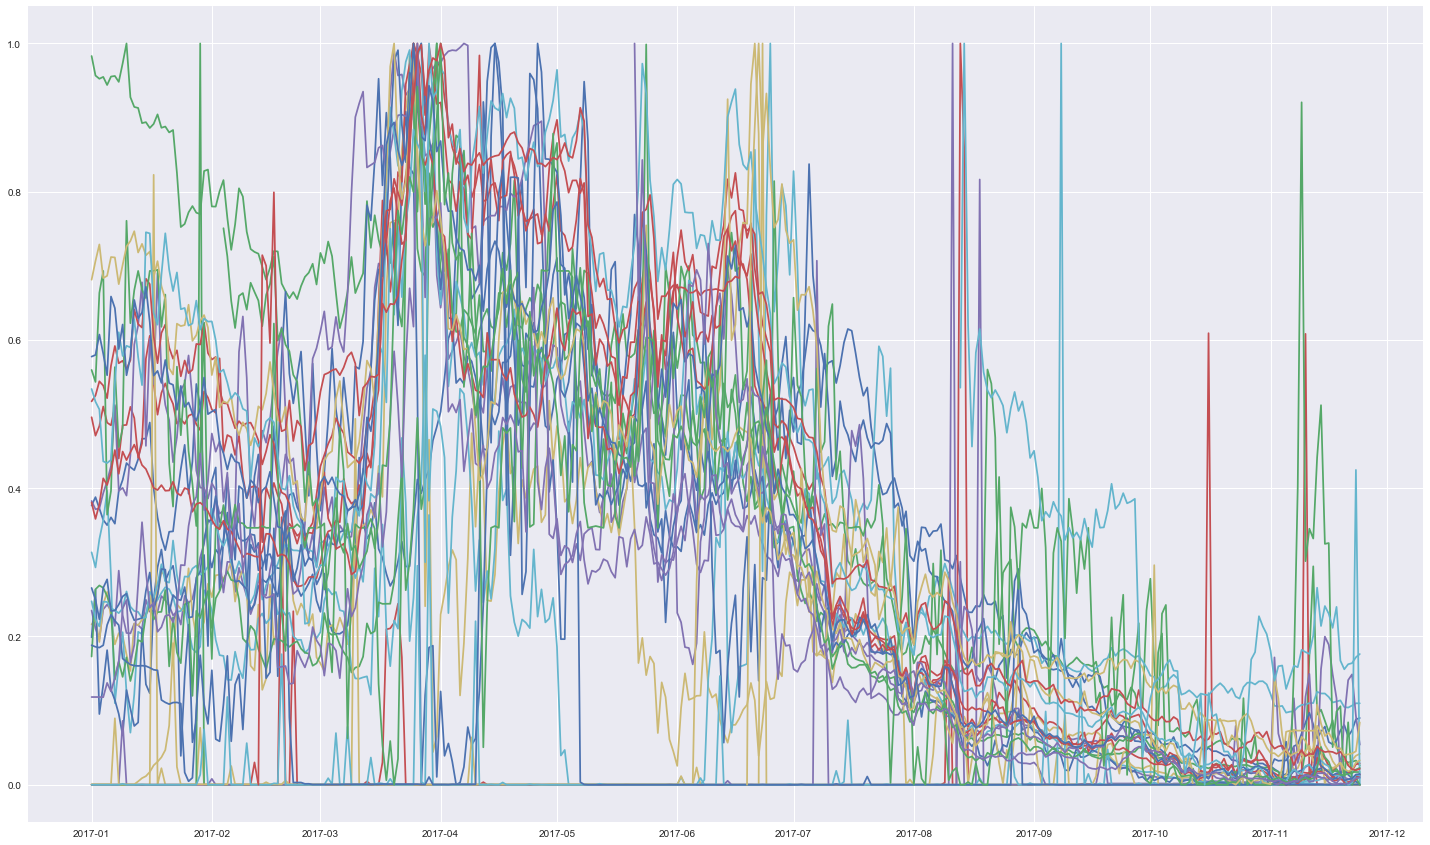

In [282]:
plt.figure(figsize=(25,15))
for alg in Alg_dict:
    plt.plot(Alg_dict[alg].index, Alg_dict[alg]['Normalized BTC'])

### Plot of all normalized BTC/Hashrate/day for all Algos.  Clearly this is a bit messy, since they are normalized let's take the mean.

In [180]:
summaryBTC = pd.DataFrame() 
for alg in Alg_dict:
    summaryBTC[alg] = Alg_dict[alg]['Normalized BTC'] 

In [181]:
summaryBTC['mean'] = summaryBTC.mean(axis=1)

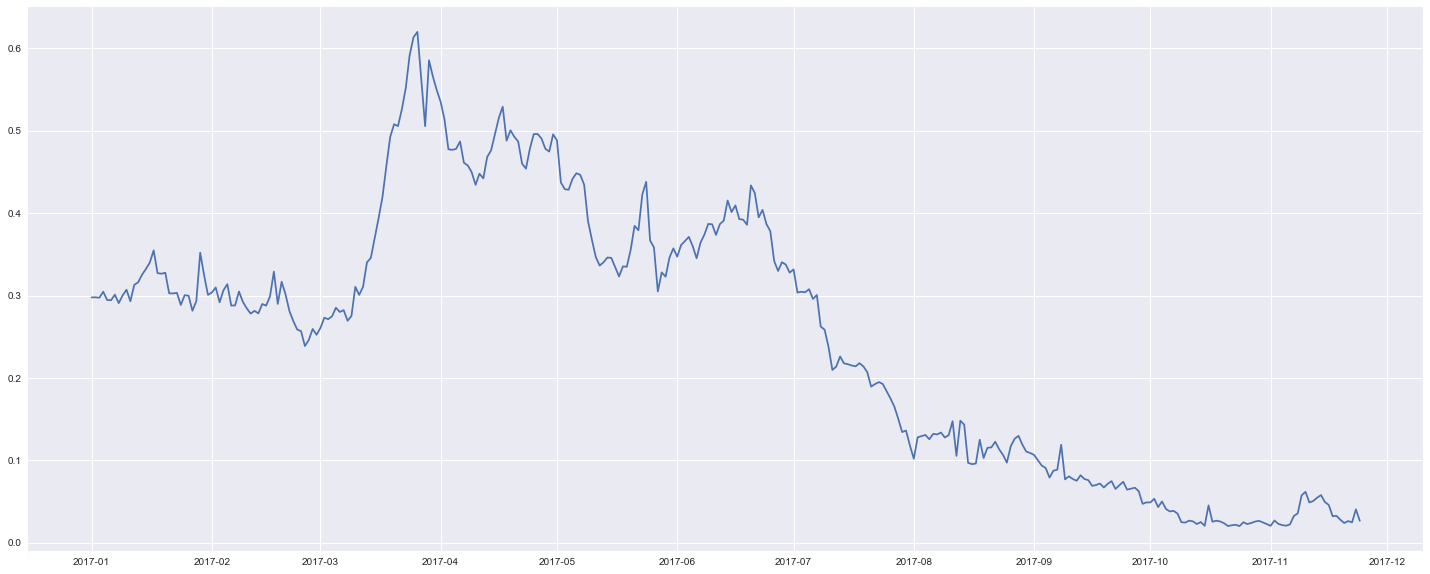

In [283]:
plt.figure(figsize=(25,10))
plt.plot(summaryBTC.index, summaryBTC['mean'])

### Mean normalized BTC/Hashrate/Day for all algos on Nicehash from Jan 1, 2017 to Nov 23, 2017.

### There's a clear downward trend in the amount of BTC earned per day per hashrate. But we should track this to the BTC price in USD to see what the USD/Hashrate/Day is.

In [183]:
summaryUSD = pd.DataFrame() 
for alg in Alg_dict:
    summaryUSD[alg] = Alg_dict[alg]['Normalized USD'] 

In [184]:
summaryUSD['mean'] = summaryUSD.mean(axis=1)

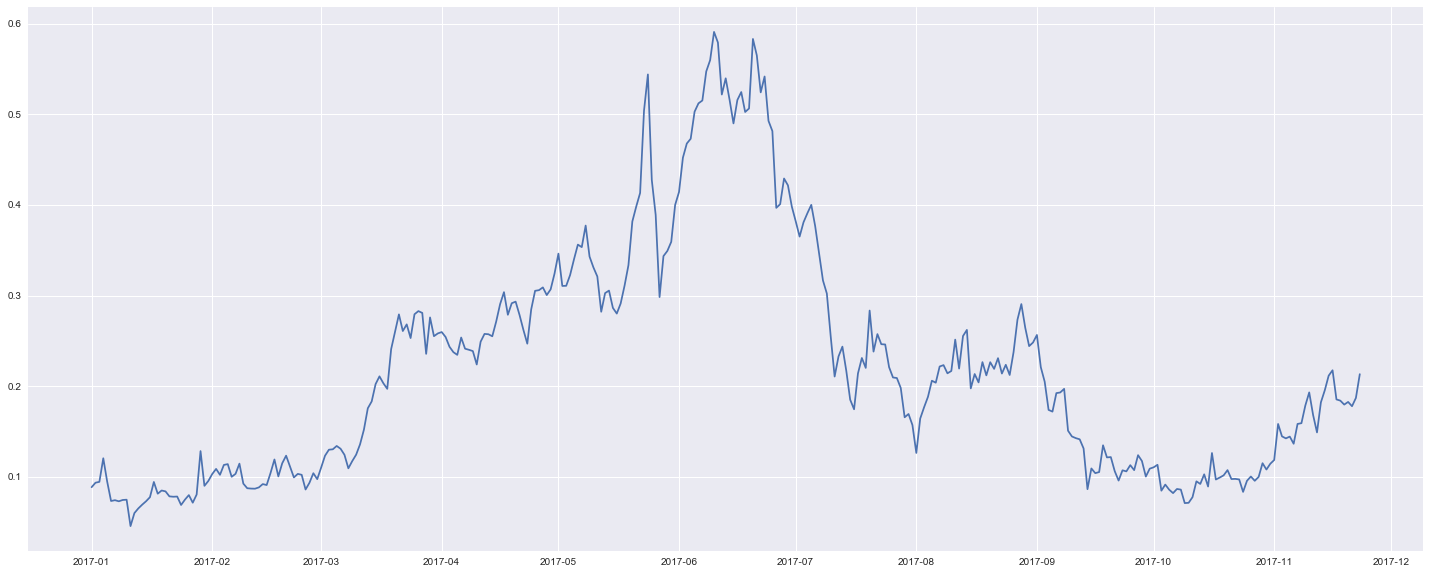

In [284]:
plt.figure(figsize=(25,10))
plt.plot(summaryUSD.index, summaryUSD['mean'])

### Normalized USD/Hashrate/Day.  Sometime at the beginning of the summer was a very profitable period of time.  There isn't as clear a trend of profitablility going down here compared to BTC gains. It might still be profitable in USD to continue GPU mining.

In [321]:
def add_days_to_frame(df):
    df['days'] = df.index - df.index[0] #convert datetime to number of days for plotting
    df['days'] = df['days'].dt.days
    return df

In [322]:
def get_btc_prices(URL):
    """
    Args: URL: from coinmarketcap.com
    
    Returns: dataframe with BTC close price over designated time frame
        and a fitted linear function over that period of time.
    """
    df = pd.read_html(URL, header=0)[0]
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[::-1].reset_index(drop=True)
    df.index = df['Date']
    df = df.drop(['Date', 'Open', 'High', 'Low', 'Volume', 'Market Cap'], 1)
    df.columns = ['BTC Close']
    #df['days'] = df.index - df.index[0] #convert datetime to number of days for plotting
    #df['days'] = df['days'].dt.days
    
    df = add_days_to_frame(df)
    
    fit = np.polyfit(df['days'], df['BTC Close'], 1)
    fit_fn = np.poly1d(fit)
    
    
    return df, fit_fn
    

### Let's track BTC price movements and get a rough trend.  This obviously isn't rigorous for accurate predictions, but we can sort of get an idea of where BTC prices may go.

In [316]:
#get bitcoin daily price from Nov 1, 2016 onwards
URL = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20161101&end=20171124'
jan2017, conservative_estimate = get_btc_prices(URL)

In [271]:
#get bitcoin daily price from May 1, 2017 onwards
URL = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20170501&end=20171124'
june2017, promising_estimate = get_btc_prices(URL)

In [323]:
#get bitcoin daily price from Aug 1, 2017 onwards
URL = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20170801&end=20171124'
aug2017, optimistic_estimate = get_btc_prices(URL)

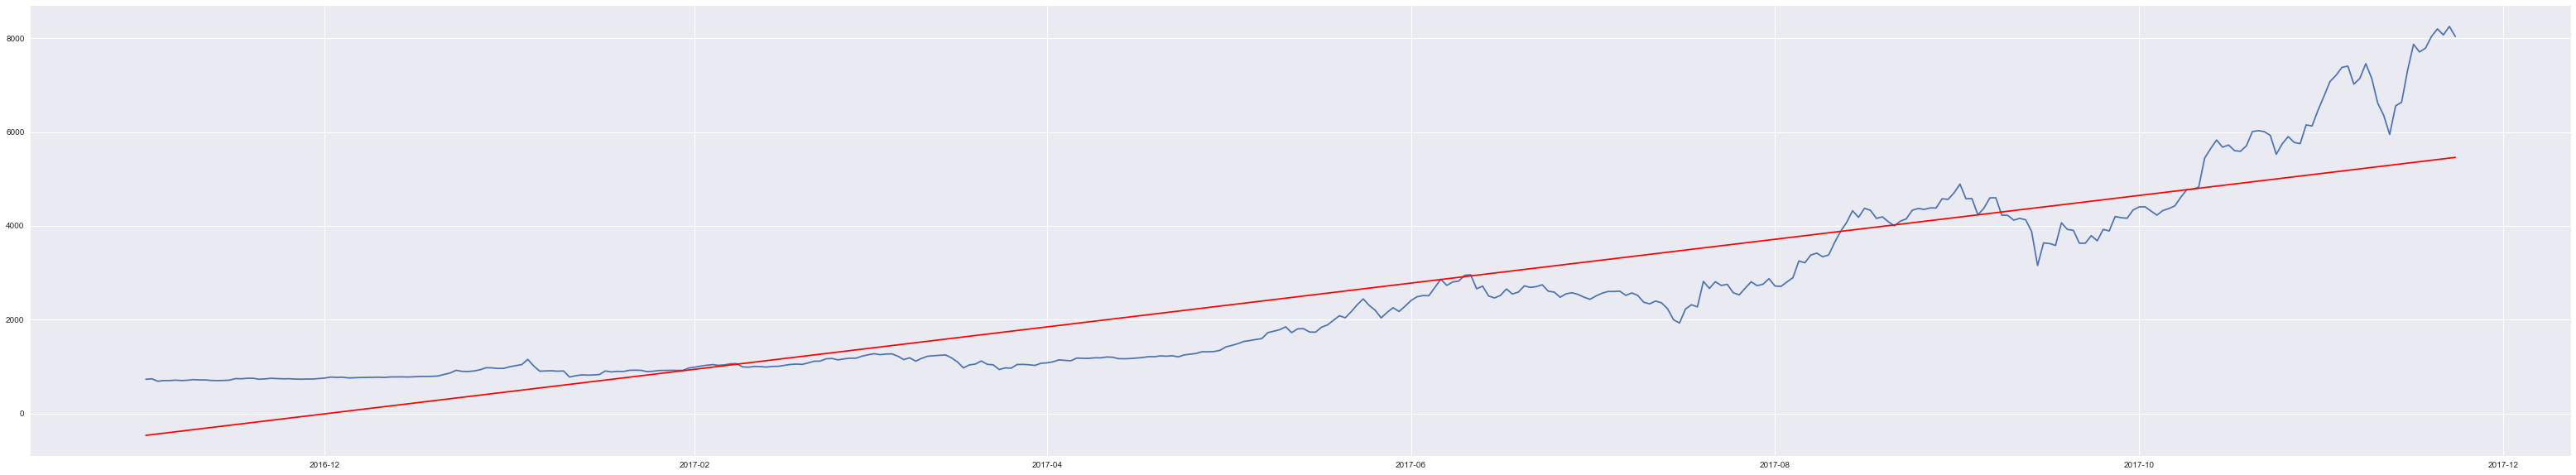

In [317]:
plt.figure(figsize=(55,10))
plt.plot(jan2017.index, jan2017['BTC Close'], jan2017.index, conservative_estimate(jan2017['days']), 'r-')

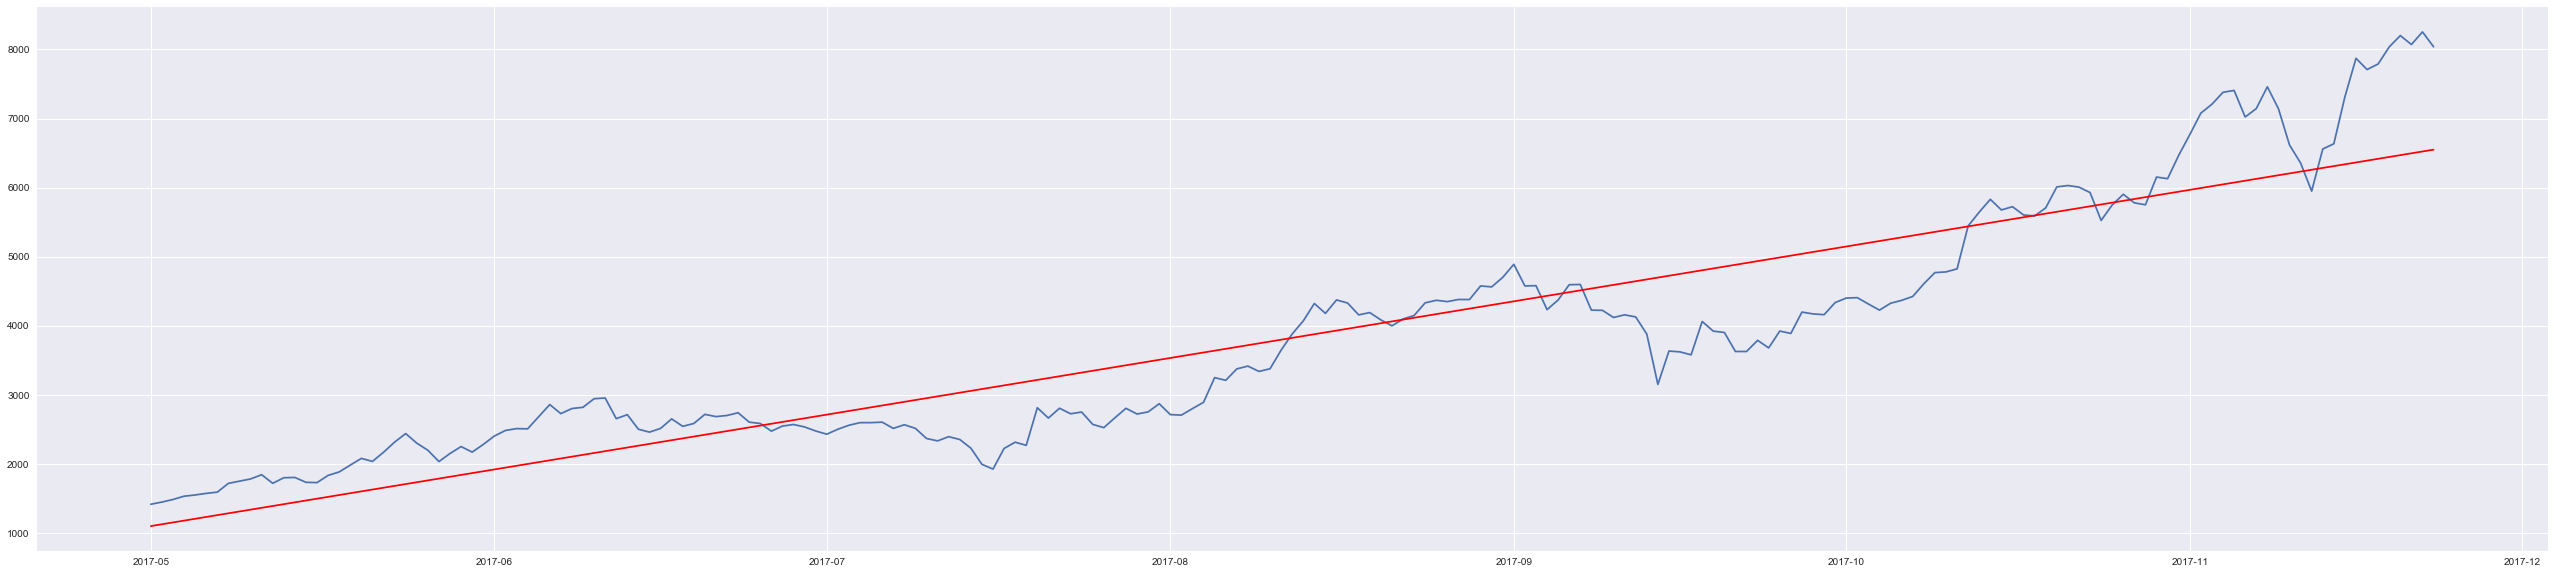

In [291]:
plt.figure(figsize=(45,10))
plt.plot(june2017.index, june2017['BTC Close'], june2017.index, promising_estimate(june2017['days']), 'r-')

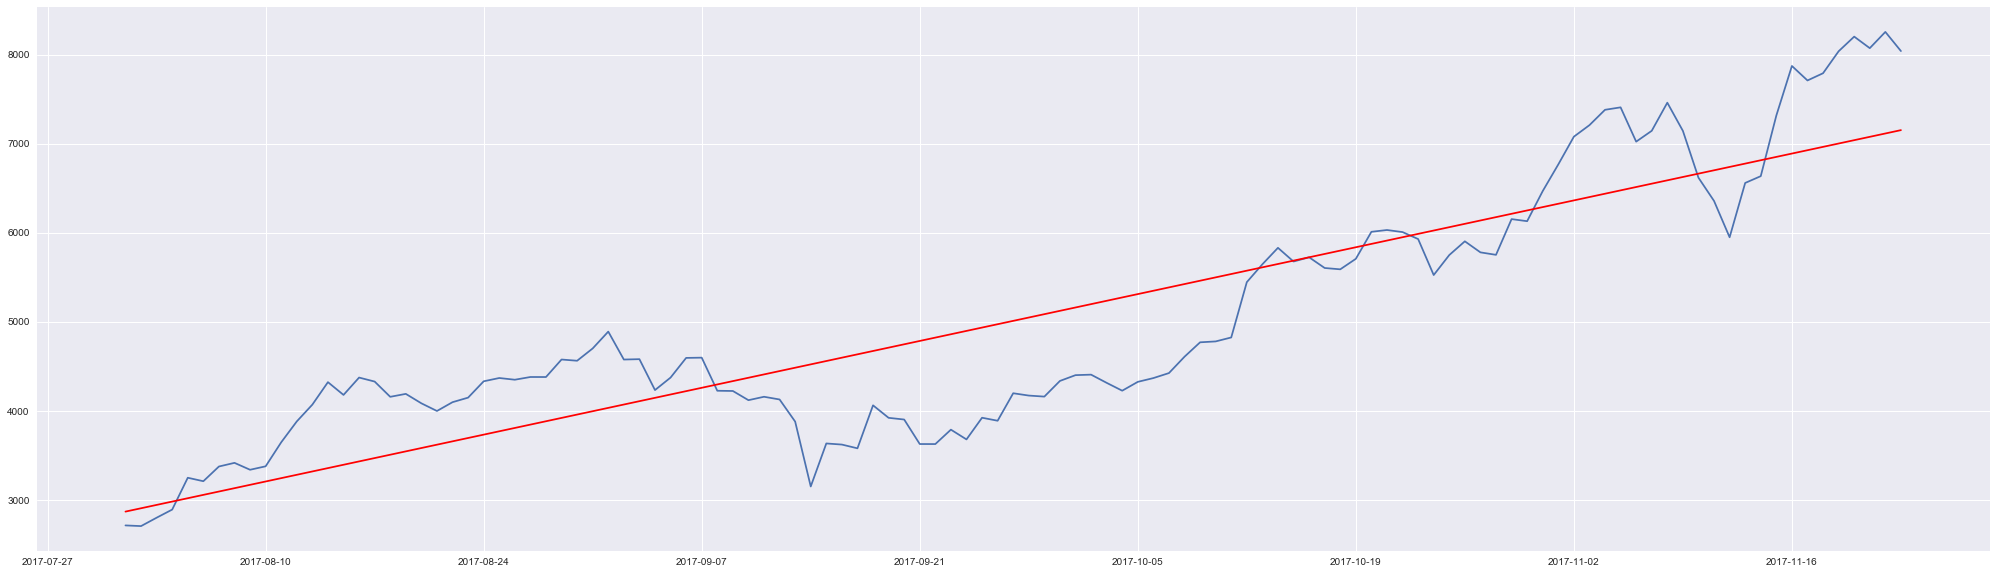

In [324]:
plt.figure(figsize=(35,10))
plt.plot(aug2017.index, aug2017['BTC Close'], aug2017.index, optimistic_estimate(aug2017['days']), 'r-')

In [308]:
aug2017['days'][-1]

114

In [309]:
june2017['days'][-1]

206

In [318]:
jan2017['days'][-1]

387

In [315]:
conservative_estimate(387+365), promising_estimate(206+365), optimistic_estimate(114+365)

(11050.621752320518, 16198.124274893302, 20851.064376864208)

#### A conservative estimate for BTC price a year from now:  11050 USD
#### Somewhat optimistic price: 16198 USD
#### Very optimistic price estimate: 20851 USD

In [360]:
summaryBTC = add_days_to_frame(summaryBTC)
fit = np.polyfit(summaryBTC['days'], np.log2(summaryBTC['mean']), 1)
fit_fn = np.poly1d(fit)

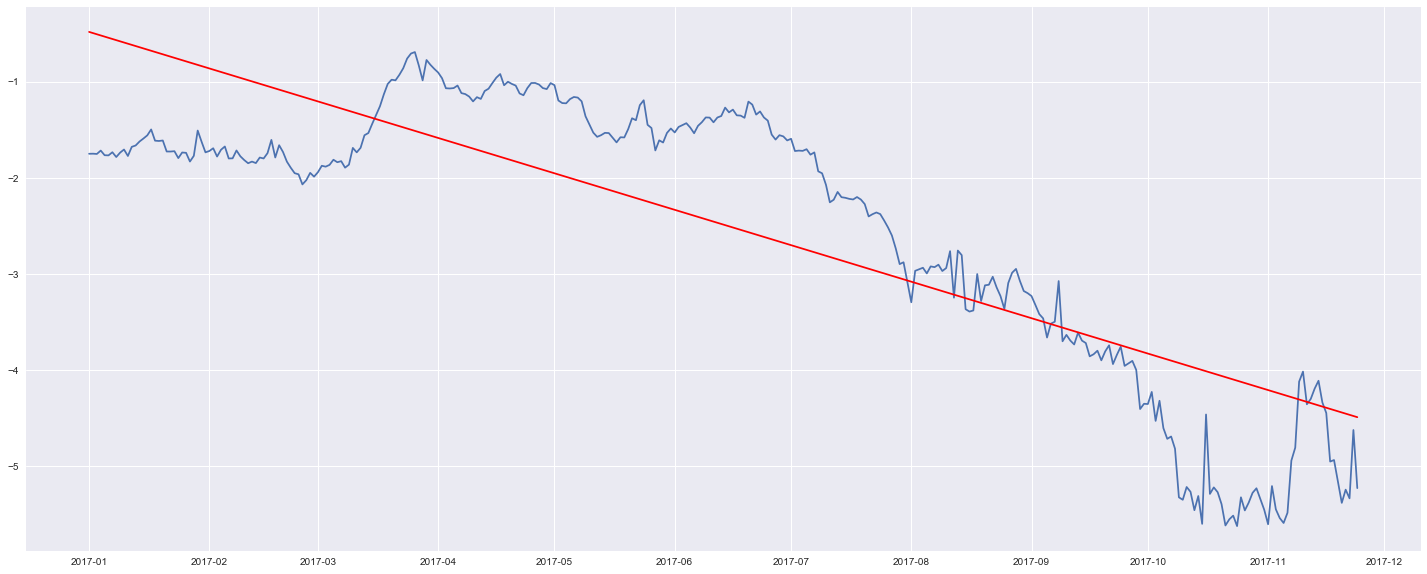

In [361]:
plt.figure(figsize=(25,10))
plt.plot(summaryBTC.index, np.log2(summaryBTC['mean']), summaryBTC.index, fit_fn(summaryBTC['days']), 'r-')

In [337]:
summaryUSD = add_days_to_frame(summaryUSD)


In [351]:
summaryUSD.fillna(method='ffill', inplace=True)

In [362]:
fit = np.polyfit(summaryUSD['days'], np.log2(summaryUSD['mean']), 1)
fit_fn = np.poly1d(fit)

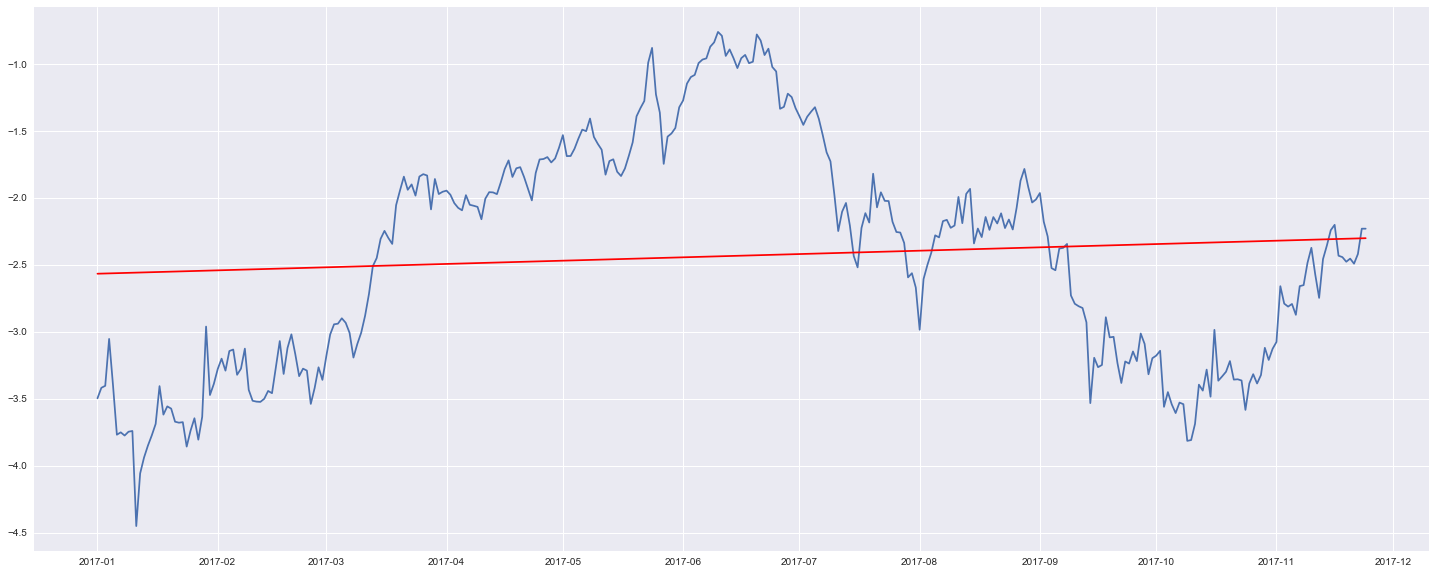

In [363]:
plt.figure(figsize=(25,10))
plt.plot(summaryUSD.index, np.log2(summaryUSD['mean']), summaryUSD.index, fit_fn(summaryUSD['days']), 'r-')

In [385]:
Alg_dict['NeoScrypt']['Profit'][0], Alg_dict['NeoScrypt']['Profit'][-1]

(1.2376850694444435, 0.2910416666666667)

In [386]:
Alg_dict['Equihash']['Profit'][0], Alg_dict['Equihash']['Profit'][-1]

(4.4536420138888921, 0.63579166666666664)

In [388]:
jan2017['BTC Close'][0], jan2017['BTC Close'][-1]

(729.78999999999996, 8038.7700000000004)

## My rough estimates for the BTC hashrate profitability decay is 15-20% per month. That means, every month, due to increasing difficulties and reduced reward, the amount of BTC you earn per hashrate decreases by roughly 15-20%.  This can be offset by an increase in BTC price, and recently it has increased quite a bit, but you can't expect BTC to grow at 10% per month.

In [419]:
def mining(START=10000, BTCPRICE=10000, BTCPERKHASH=0.01, HASH_DECAY=0.19, BTC_GROWTH=0.05, MONTHS=12):
    KHASH = START/1000
    btc_income = 0
    for i in range(MONTHS):
        btc_income += KHASH * BTCPERKHASH
        BTCPERKHASH -= BTCPERKHASH*HASH_DECAY
        BTCPRICE += BTCPRICE*BTC_GROWTH
    
    return [BTCPERKHASH, btc_income, BTCPRICE, btc_income*BTCPRICE]
    
    
        
        

In [441]:
mining(START=10000, HASH_DECAY=0.15, BTC_GROWTH=0.05)

[0.0014224175713617216,
 0.5718388285758852,
 17958.56326022129,
 10269.403777630872]

In [403]:
def invest(START=10000, BTCPRICE=10000, BTC_GROWTH=0.05, MONTHS=12):
    bought = START/BTCPRICE
    for i in range(MONTHS):
        BTCPRICE += BTCPRICE*BTC_GROWTH
    return bought*BTCPRICE
    

In [416]:
invest(START=8000, BTC_GROWTH=0.05)

14366.850608177032

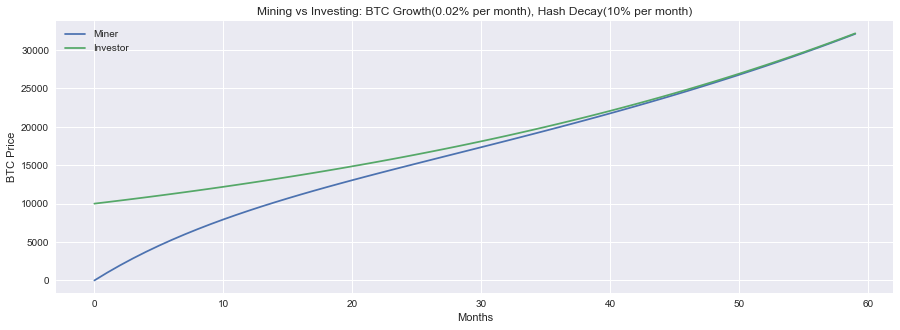

In [520]:
miner = []
investor = []
for i in range(60):
    miner.append(mining(START=10000, HASH_DECAY=0.10, BTC_GROWTH=0.02, MONTHS=i))
    investor.append(invest(START=10000, BTC_GROWTH=0.02, MONTHS=i))

df1 = pd.DataFrame(miner)
df2 = pd.DataFrame(investor)

plt.figure(figsize=(15,5))
plt.plot(df1[3], label='Miner')
plt.plot(df2[0], label='Investor')
plt.title('Mining vs Investing: BTC Growth(0.02% per month), Hash Decay(10% per month)')
plt.xlabel('Months')
plt.ylabel('BTC Price')
plt.legend()

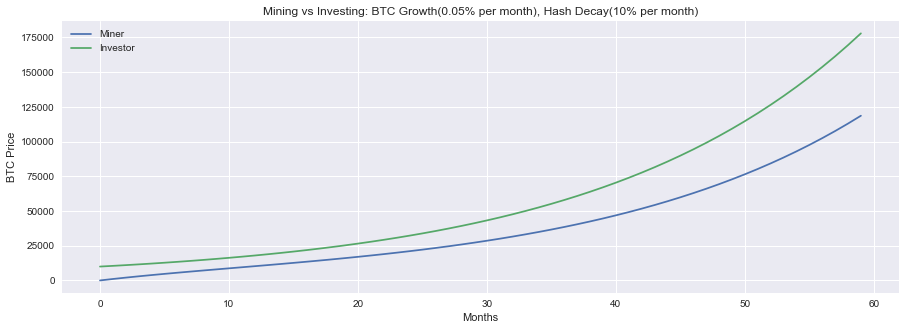

In [519]:
miner = []
investor = []
for i in range(60):
    miner.append(mining(START=10000, HASH_DECAY=0.15, BTC_GROWTH=0.05, MONTHS=i))
    investor.append(invest(START=10000, BTC_GROWTH=0.05, MONTHS=i))

df1 = pd.DataFrame(miner)
df2 = pd.DataFrame(investor)

plt.figure(figsize=(15,5))
plt.plot(df1[3], label='Miner')
plt.plot(df2[0], label='Investor')
plt.title('Mining vs Investing: BTC Growth(0.05% per month), Hash Decay(10% per month)')
plt.xlabel('Months')
plt.ylabel('BTC Price')
plt.legend()

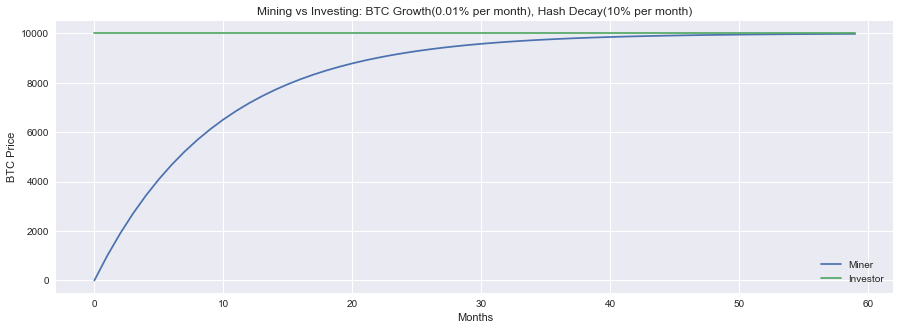

In [509]:
miner = []
investor = []
for i in range(60):
    miner.append(mining(START=10000, HASH_DECAY=0.10, BTC_GROWTH=0.00, MONTHS=i))
    investor.append(invest(START=10000, BTC_GROWTH=0.00, MONTHS=i))

df1 = pd.DataFrame(miner)
df2 = pd.DataFrame(investor)

plt.figure(figsize=(15,5))
plt.plot(df1[3], label='Miner')
plt.plot(df2[0], label='Investor')
plt.title('Mining vs Investing: BTC Growth(0.00% per month), Hash Decay(10% per month)')
plt.xlabel('Months')
plt.ylabel('BTC Price')
plt.legend()

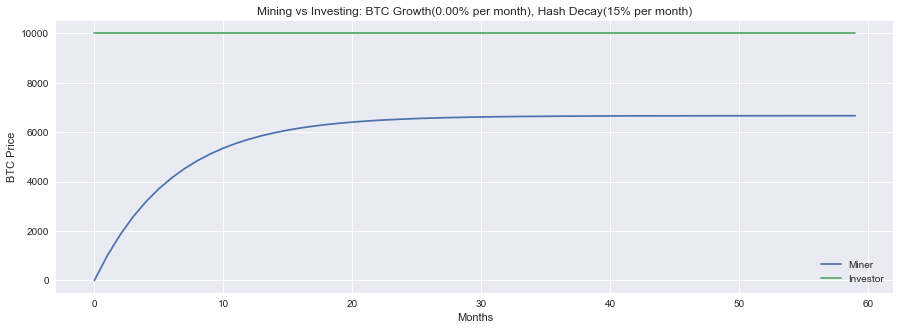

In [510]:
miner = []
investor = []
for i in range(60):
    miner.append(mining(START=10000, HASH_DECAY=0.15, BTC_GROWTH=0.00, MONTHS=i))
    investor.append(invest(START=10000, BTC_GROWTH=0.00, MONTHS=i))

df1 = pd.DataFrame(miner)
df2 = pd.DataFrame(investor)

plt.figure(figsize=(15,5))
plt.plot(df1[3], label='Miner')
plt.plot(df2[0], label='Investor')
plt.title('Mining vs Investing: BTC Growth(0.00% per month), Hash Decay(15% per month)')
plt.xlabel('Months')
plt.ylabel('BTC Price')
plt.legend()

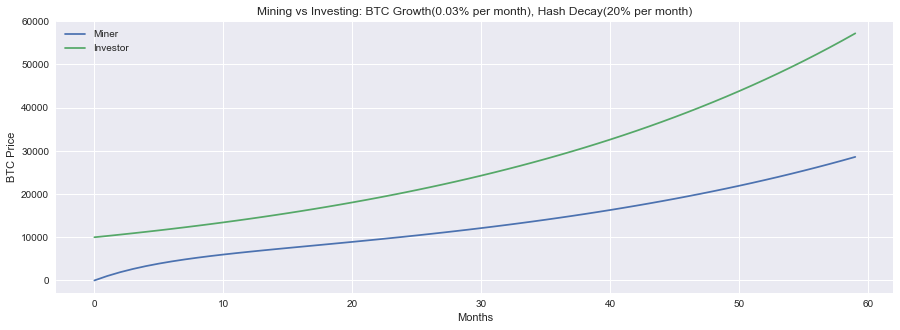

In [518]:
miner = []
investor = []
for i in range(60):
    miner.append(mining(START=10000, HASH_DECAY=0.2, BTC_GROWTH=0.03, MONTHS=i))
    investor.append(invest(START=10000, BTC_GROWTH=0.03, MONTHS=i))

df1 = pd.DataFrame(miner)
df2 = pd.DataFrame(investor)

plt.figure(figsize=(15,5))
plt.plot(df1[3], label='Miner')
plt.plot(df2[0], label='Investor')
plt.title('Mining vs Investing: BTC Growth(0.03% per month), Hash Decay(20% per month)')
plt.xlabel('Months')
plt.ylabel('BTC Price')
plt.legend()

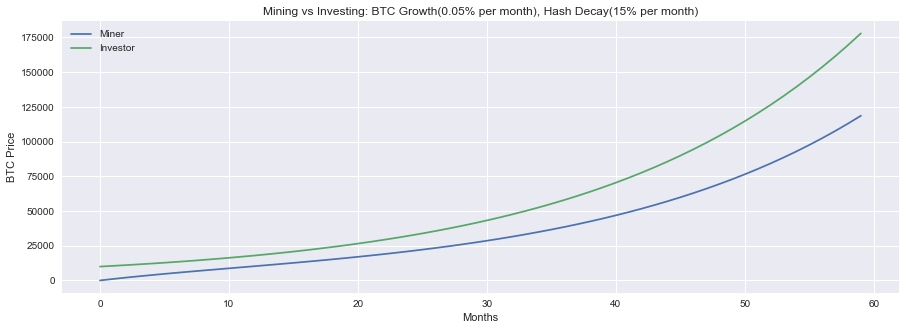

In [517]:
miner = []
investor = []
for i in range(60):
    miner.append(mining(START=10000, HASH_DECAY=0.15, BTC_GROWTH=0.05, MONTHS=i))
    investor.append(invest(START=10000, BTC_GROWTH=0.05, MONTHS=i))

df1 = pd.DataFrame(miner)
df2 = pd.DataFrame(investor)

plt.figure(figsize=(15,5))
plt.plot(df1[3], label='Miner')
plt.plot(df2[0], label='Investor')
plt.title('Mining vs Investing: BTC Growth(0.05% per month), Hash Decay(15% per month)')
plt.xlabel('Months')
plt.ylabel('BTC Price')
plt.legend()